In [1]:
import os
smoke_test = ('CI' in os.environ)  # for continuous integration tests

# various import statements
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn.functional import softplus, softmax, sigmoid
from torch.distributions import constraints
from torch.optim import Adam

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.contrib.examples.scanvi_data import get_data

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scvelo as scv

In [2]:
# Helper for making fully-connected neural networks
def make_fc(dims):
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.Softplus())
    return nn.Sequential(*layers[:-1])  # Exclude final Softplus non-linearity

# Splits a tensor in half along the final dimension
def split_in_half(t):
    return t.reshape(t.shape[:-1] + (2, -1)).unbind(-2)
# Used in parameterizing p(s | z2)
class UDecoder(nn.Module):
    # This __init__ statement is executed once upon construction of the neural network.
    # Here we specify that the neural network has input dimension z2_dim
    # and output dimension num_genes.
    def __init__(self, num_genes, z_dim, hidden_dims):
        super().__init__()
        # Create a list to store the layers
        dims = [z_dim] + hidden_dims + [2 * num_genes]
        self.fc = make_fc(dims)
    # This method defines the actual computation of the neural network. It takes
    # z2 as input and spits out two parameters that are then used in the model
    # to define the ZINB observation distribution. In particular it generates
    # `gate_logits`, which controls zero-inflation, and `mu` which encodes the
    # relative frequencies of different genes.
    def forward(self, z):
        gate, mu = split_in_half(self.fc(z))
        # Note that mu is normalized so that total count information is
        # encoded by the latent variable ℓ.
        mu = softmax(mu, dim=-1)
        # gate = sigmoid(gate)
        return gate, mu

In [3]:
class SDecoder(nn.Module):
    # This __init__ statement is executed once upon construction of the neural network.
    # Here we specify that the neural network has input dimension z2_dim
    # and output dimension num_genes.
    def __init__(self, num_genes, z_dim, hidden_dims):
        super().__init__()
        # Create a list to store the layers
        dims = [z_dim] + hidden_dims + [2 * num_genes]
        self.fc = make_fc(dims)
    # This method defines the actual computation of the neural network. It takes
    # z2 as input and spits out two parameters that are then used in the model
    # to define the ZINB observation distribution. In particular it generates
    # `gate_logits`, which controls zero-inflation, and `mu` which encodes the
    # relative frequencies of different genes.
    def forward(self, z):
        gate, ssr = split_in_half(self.fc(z))
        # Note that mu is normalized so that total count information is
        # encoded by the latent variable ℓ.
        ssr = softplus(ssr)
        # gate = sigmoid(gate)
        return gate, ssr

In [4]:
# Used in parameterizing q(sl | s)
class LEncoder(nn.Module):
    def __init__(self, num_genes, hidden_dims):
        super().__init__()
        dims = [num_genes] + hidden_dims + [2]
        self.fc = make_fc(dims)

    def forward(self, s):
        # Transform the counts x to log space for increased numerical stability.
        # Note that we only use this transformation here; in particular the observation
        # distribution in the model is a proper count distribution.
        s = torch.log(1 + s)
        l_loc, l_scale = split_in_half(self.fc(s))
        l_scale = softplus(l_scale)
        return l_loc, l_scale

In [5]:
# Used in parameterizing p(z2 | z1, s)
class XEncoder(nn.Module):
    def __init__(self, z_dim,num_genes, hidden_dims):
        super().__init__()
        dims = [2* num_genes] + hidden_dims + [2 * z_dim]
        self.fc = make_fc(dims)

    def forward(self, u, s):
        u = u.type(torch.float32)
        s = s.type(torch.float32)
        x = torch.cat([s, u], dim=-1)
        # We reshape the input to be two-dimensional so that nn.BatchNorm1d behaves correctly
        x = x.reshape(-1, x.size(-1))
        hidden = self.fc(x)
        # If the input was three-dimensional we now restore the original shape
        hidden = hidden.reshape(x.shape[:-1] + hidden.shape[-1:])
        loc, scale = split_in_half(hidden)
        # Here and elsewhere softplus ensures that scale is positive. Note that we generally
        # expect softplus to be more numerically stable than exp.
        scale = softplus(scale)
        return loc, scale

In [6]:
class VAE(nn.Module):
    def __init__(self, num_genes, sl_loc, sl_scale, ul_loc, ul_scale,
                 latent_dim=10, alpha=0.01, scale_factor=1.0):
        self.num_genes = num_genes

        # This is the dimension of both z1 and z2
        self.latent_dim = latent_dim

        # The next two hyperparameters determine the prior over the log_count latent variable `l`
        self.ul_loc = ul_loc
        self.ul_scale = ul_scale
        self.sl_loc = sl_loc
        self.sl_scale = sl_scale

        # This hyperparameter controls the strength of the auxiliary classification loss
        # self.alpha = alpha
        self.scale_factor = scale_factor

        super().__init__()

        # Setup the various neural networks used in the model and guide
        self.x_encoder = XEncoder(z_dim=self.latent_dim, num_genes=self.num_genes,
                                    hidden_dims=[128 , 64])
        self.u_decoder = UDecoder(num_genes=num_genes, hidden_dims=[64, 128], z_dim=self.latent_dim)
        self.s_decoder = SDecoder(num_genes=num_genes, hidden_dims=[64, 128], z_dim=self.latent_dim)
        self.sl_encoder = LEncoder(num_genes=num_genes, hidden_dims=[64 , 32])
        self.ul_encoder = LEncoder(num_genes=num_genes, hidden_dims=[64 , 32])

        self.epsilon = 0.003

    def model(self, u, s):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("VAE", self)

        # This gene-level parameter modulates the variance of the observation distribution
        theta_u = pyro.param("inverse_dispersion_unspliced", 100.0 * u.new_ones(self.num_genes),
                           constraint=constraints.positive)
        theta_s = pyro.param("inverse_dispersion_spliced", 100.0 * s.new_ones(self.num_genes),
                           constraint=constraints.positive)

        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        with pyro.plate("batch", len(u)), poutine.scale(scale=self.scale_factor):
            z = pyro.sample("z", dist.Normal(0, u.new_ones(self.latent_dim)).to_event(1))
            
            # y = pyro.sample("y", dist.OneHotCategorical(logits=x.new_zeros(self.num_labels)),
            #                 obs=y)
            gate_logits_u, mu_u = self.u_decoder(z)
            ul_scale = self.ul_scale * u.new_ones(1)
            ul = pyro.sample("ul", dist.LogNormal(self.ul_loc, ul_scale).to_event(1))
            rate_u = (ul * mu_u + self.epsilon).log() - (theta_u + self.epsilon).log()
            # u_dist = dist.ZeroInflatedPoisson(gate=gate_u, rate = rate_u)
            u_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_u, total_count=theta_u,
                                                       logits=rate_u)
            u_hat = pyro.sample("u", u_dist.to_event(1), obs=u)


            sl_scale = self.sl_scale * s.new_ones(1)
            sl = pyro.sample("sl", dist.LogNormal(self.sl_loc, sl_scale).to_event(1))
            # Note that by construction mu is normalized (i.e. mu.sum(-1) == 1) and the
            # total scale of counts for each cell is determined by `l`
            gate_logits_s, ssr = self.s_decoder(z)
            rate_s = (s * mu_u * ssr + self.epsilon).log() - (theta_s + self.epsilon).log()
            # indices_greater_than_one = torch.nonzero(torch.exp(nb_logits_s) >1).squeeze()
            # s_dist = dist.ZeroInflatedPoisson(gate=gate_s, rate = rate_s)
            s_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_s, total_count=theta_s,
                                                       logits=rate_s)
            # Observe the datapoint x using the observation distribution x_dist
            pyro.sample("s", s_dist.to_event(1), obs=s)

    # The guide specifies the variational distribution
    def guide(self, u, s):
        pyro.module("VAE", self)
        with pyro.plate("batch", len(u)), poutine.scale(scale=self.scale_factor):
            z_loc , z_scale = self.x_encoder(u,s)
            sl_loc, sl_scale = self.sl_encoder(s)
            pyro.sample("sl", dist.LogNormal(sl_loc, sl_scale).to_event(1))
            pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

            ul_loc, ul_scale = self.ul_encoder(u)
            pyro.sample("ul", dist.LogNormal(ul_loc, ul_scale).to_event(1))


In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import scvelo as scv

def preprocess_and_create_dataloader(adata, batch_size = 128):
    # Filter genes based on shared counts
    scv.pp.filter_genes(adata, min_shared_counts=20)
    
    # Normalize per cell
    scv.pp.normalize_per_cell(adata)
    
    # Filter genes based on dispersion
    scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
    scv.pp.log1p(adata)
    # Filter and normalize based on shared counts and top genes
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    
    # Access the 'spliced' layer
    spliced_counts = adata.layers['spliced']

    # Access the 'unspliced' layer
    unspliced_counts = adata.layers['unspliced']
    
    # Convert to PyTorch tensors
    spliced_tensor = torch.tensor(spliced_counts.toarray())
    unspliced_tensor = torch.tensor(unspliced_counts.toarray())
    
    # Check if the shapes match
    assert spliced_tensor.shape == unspliced_tensor.shape
    
    # Create a PyTorch dataset
    dataset = TensorDataset(spliced_tensor, unspliced_tensor)
    
    # Model's first hyperparameter
    
    # Create a PyTorch DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader, adata, spliced_tensor, unspliced_tensor


In [8]:
def prepare_vae(adata, batch_size=128):
    num_genes = len(adata.var)

    # Calculate library size (total counts) for each cell
    spliced_library_size = np.log(adata.layers['spliced'].sum(axis=1))

    # Calculate mean and scale for spliced layer
    sl_mean = spliced_library_size.mean()
    sl_scale = spliced_library_size.std()

    # Calculate library size for unspliced layer
    unspliced_library_size = np.log(adata.layers['unspliced'].sum(axis=1))

    # Calculate mean and scale for unspliced layer
    ul_mean = unspliced_library_size.mean()
    ul_scale = unspliced_library_size.std()

    # Instantiate instance of model/guide and various neural networks
    vae = VAE(num_genes=num_genes,
              sl_loc=sl_mean, sl_scale=sl_scale, ul_loc=ul_mean, ul_scale=ul_scale,
              scale_factor=1.0 / (batch_size * num_genes))

    return vae

In [9]:
from tqdm import tqdm
def train_vae(adata,data_loader, num_epochs=80,batch_size = 128, smoke_test=False):
    # Clear Pyro param store so we don't conflict with previous
    # training runs in this session
    pyro.clear_param_store()

    # Fix random number seed
    pyro.util.set_rng_seed(0)

    # Enable optional validation warnings
    pyro.enable_validation(True)

    num_genes = len(adata.var)
    vae = prepare_vae(adata, batch_size)
    if not smoke_test:
        vae = vae.cuda()

    # Setup an optimizer (Adam) and learning rate scheduler.
    # We start with a moderately high learning rate (0.006) and
    # reduce by a factor of 5 after 20 epochs.
    scheduler = MultiStepLR({'optimizer': Adam,
                             'optim_args': {'lr': 0.006},
                             'gamma': 0.2, 'milestones': [20]},
                              {"clip_norm": 10.0})

    # Setup a variational objective for gradient-based learning.
    # Note we use TraceEnum_ELBO in order to leverage Pyro's machinery
    # for automatic enumeration of the discrete latent variable y.
    elbo = TraceEnum_ELBO(strict_enumeration_warning=False)
    svi = SVI(vae.model, vae.guide, scheduler, elbo)

    # Training loop.
    # We train for num_epochs epochs.
    # For optimal results, tweak the optimization parameters.
    # For our purposes, 80 epochs of training is sufficient.
    # Training should take about 8 minutes on a GPU-equipped Colab instance.

    losses = []

    for epoch in range(num_epochs):
        epoch_losses = []

        # Take a gradient step for each mini-batch in the dataset
        for s, u in tqdm(data_loader, desc=f'Epoch {epoch}'):
            s, u = s.cuda(), u.cuda()
            u = u.type(torch.int)
            s = s.type(torch.int)
            loss = svi.step(u, s)
            epoch_losses.append(loss)

        # Tell the scheduler we've done one epoch.
        scheduler.step()

        epoch_loss_mean = np.mean(epoch_losses)
        losses.append(epoch_loss_mean)

        if epoch%10 ==0:
            print(f"[Epoch {epoch}]  Loss: {epoch_loss_mean:.5f}")

    print("Finished training!")

    # Plot the loss function
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return vae


Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 55 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


/tmp/ipykernel_24083/4122186154.py:14: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)
/home/arataz/NDE/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.


Epoch 0: 100%|██████████| 29/29 [00:02<00:00,  9.78it/s]


[Epoch 0]  Loss: 5.43853


Epoch 10: 100%|██████████| 29/29 [00:01<00:00, 19.03it/s]


[Epoch 10]  Loss: 3.12916


Epoch 20: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


[Epoch 20]  Loss: 2.02562


Epoch 30: 100%|██████████| 29/29 [00:01<00:00, 18.92it/s]


[Epoch 30]  Loss: 1.86983


Epoch 40: 100%|██████████| 29/29 [00:01<00:00, 18.98it/s]


[Epoch 40]  Loss: 1.74373


Epoch 50: 100%|██████████| 29/29 [00:01<00:00, 19.00it/s]


[Epoch 50]  Loss: 1.64141


Epoch 60: 100%|██████████| 29/29 [00:01<00:00, 19.03it/s]


[Epoch 60]  Loss: 1.55274


Epoch 70: 100%|██████████| 29/29 [00:01<00:00, 19.07it/s]


[Epoch 70]  Loss: 1.47907


Epoch 80: 100%|██████████| 29/29 [00:01<00:00, 19.03it/s]


[Epoch 80]  Loss: 1.41999


Epoch 90: 100%|██████████| 29/29 [00:01<00:00, 19.03it/s]


[Epoch 90]  Loss: 1.37241


Epoch 99: 100%|██████████| 29/29 [00:01<00:00, 18.99it/s]


Finished training!


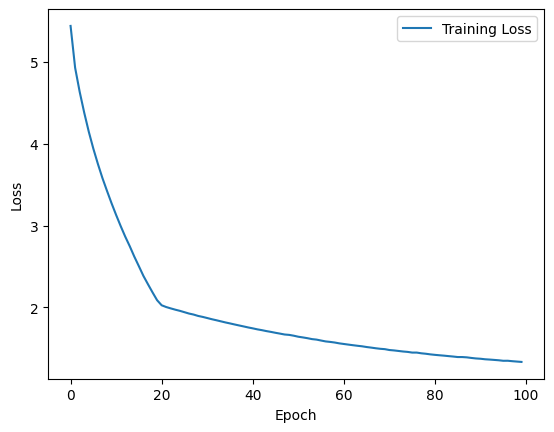

In [10]:
adata = scv.datasets.pancreas()
data_loader, adata, spliced_counts, unspliced_counts = preprocess_and_create_dataloader(adata, batch_size=128)
trained_vae = train_vae(adata,data_loader, num_epochs=100)

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt

def plot_umaps_side_by_side(adata,spliced_tensor, unspliced_tensor, vae,color):
    # Plot the original UMAP
    plt.figure(figsize=(12, 5))
    sc.pl.umap(adata, color= color, legend_loc='on data', save='scVelo_umap_plot.png')

    # Generate latent representations using the trained VAE
    vae.eval()
    latent_rep = vae.x_encoder( unspliced_tensor.cuda(), spliced_tensor.cuda())[0]
    adata.obsm["latent_rep"] = latent_rep.data.cpu().numpy()

    # Update neighbors and UMAP with latent representations
    sc.pp.neighbors(adata, use_rep="latent_rep")
    sc.tl.umap(adata)

    # Plot the UMAP based on VAE latent representations
    sc.pl.umap(adata, color= color, legend_loc='on data', save='LSD_umap_plot.png')



<Figure size 1200x500 with 0 Axes>

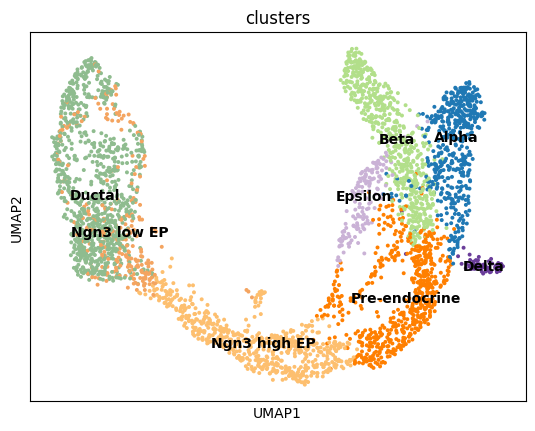

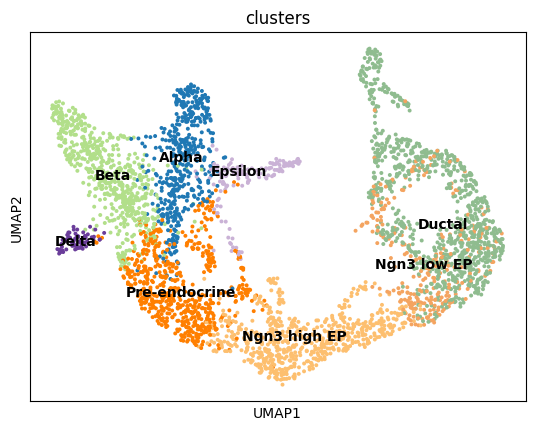

In [12]:
plot_umaps_side_by_side(adata,spliced_counts, unspliced_counts, trained_vae,'clusters')

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


/tmp/ipykernel_24083/4122186154.py:14: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


Filtered out 51 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/home/arataz/NDE/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
Epoch 0: 100%|██████████| 77/77 [00:03<00:00, 19.33it/s]


[Epoch 0]  Loss: 13.75812


Epoch 10: 100%|██████████| 77/77 [00:03<00:00, 19.66it/s]


[Epoch 10]  Loss: 3.30750


Epoch 20: 100%|██████████| 77/77 [00:03<00:00, 19.66it/s]


[Epoch 20]  Loss: 2.32678


Epoch 30: 100%|██████████| 77/77 [00:03<00:00, 19.61it/s]


[Epoch 30]  Loss: 2.25093


Epoch 40: 100%|██████████| 77/77 [00:03<00:00, 19.65it/s]


[Epoch 40]  Loss: 2.18311


Epoch 50: 100%|██████████| 77/77 [00:04<00:00, 18.29it/s]


[Epoch 50]  Loss: 2.12778


Epoch 60: 100%|██████████| 77/77 [00:03<00:00, 19.46it/s]


[Epoch 60]  Loss: 2.08611


Epoch 70: 100%|██████████| 77/77 [00:03<00:00, 19.62it/s]


[Epoch 70]  Loss: 2.05292


Epoch 80: 100%|██████████| 77/77 [00:03<00:00, 19.60it/s]


[Epoch 80]  Loss: 2.02385


Epoch 89: 100%|██████████| 77/77 [00:03<00:00, 19.54it/s]


Finished training!


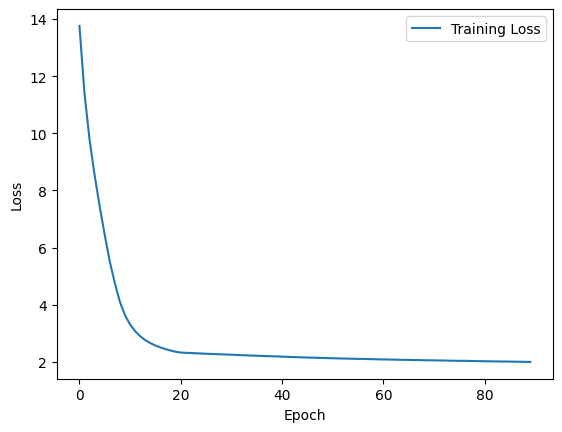

In [13]:
adata = scv.datasets.gastrulation_erythroid()
data_loader, adata, spliced_counts, unspliced_counts = preprocess_and_create_dataloader(adata, batch_size=128)
trained_vae = train_vae(adata,data_loader, num_epochs=90)

<Figure size 1200x500 with 0 Axes>

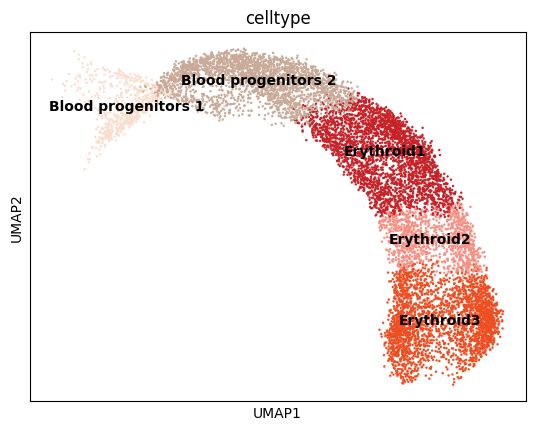

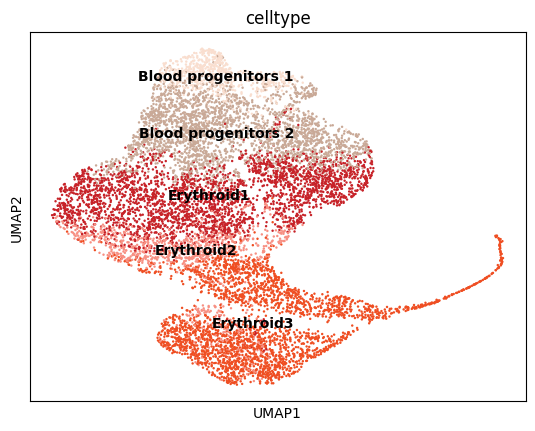

In [14]:
plot_umaps_side_by_side(adata,spliced_counts, unspliced_counts, trained_vae,'celltype')

In [23]:
import scanpy as sc
import matplotlib.pyplot as plt

def plot_tsne_side_by_side(adata,spliced_tensor, unspliced_tensor, vae,color):
    # Plot the original UMAP
    plt.figure(figsize=(12, 5))
    sc.pl.tsne(adata, color=color, legend_loc='on data',save='scVelo_tsne_plot.png')

    # Generate latent representations using the trained VAE
    vae.eval()
    latent_rep = vae.x_encoder(unspliced_tensor.cuda(), spliced_tensor.cuda())[0]
    adata.obsm["latent_rep"] = latent_rep.data.cpu().numpy()

    # Update neighbors and UMAP with latent representations
    sc.pp.neighbors(adata, use_rep="latent_rep")
    sc.tl.umap(adata)

    # Plot the UMAP based on VAE latent representations
    sc.pl.umap(adata, color= color, legend_loc='on data', save='LSD_tsne_plot.png')


Filtered out 7837 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


/tmp/ipykernel_24083/4122186154.py:14: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


Filtered out 79 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


/home/arataz/NDE/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.


Epoch 0: 100%|██████████| 46/46 [00:02<00:00, 19.17it/s]


[Epoch 0]  Loss: 2.88428


Epoch 10: 100%|██████████| 46/46 [00:02<00:00, 19.70it/s]


[Epoch 10]  Loss: 1.48472


Epoch 20: 100%|██████████| 46/46 [00:02<00:00, 19.73it/s]


[Epoch 20]  Loss: 0.93230


Epoch 30: 100%|██████████| 46/46 [00:02<00:00, 19.61it/s]


[Epoch 30]  Loss: 0.87687


Epoch 40: 100%|██████████| 46/46 [00:02<00:00, 19.63it/s]


[Epoch 40]  Loss: 0.83234


Epoch 50: 100%|██████████| 46/46 [00:02<00:00, 19.56it/s]


[Epoch 50]  Loss: 0.79670


Epoch 60: 100%|██████████| 46/46 [00:02<00:00, 19.58it/s]


[Epoch 60]  Loss: 0.77318


Epoch 70: 100%|██████████| 46/46 [00:02<00:00, 19.37it/s]


[Epoch 70]  Loss: 0.75600


Epoch 80: 100%|██████████| 46/46 [00:02<00:00, 19.61it/s]


[Epoch 80]  Loss: 0.74490


Epoch 89: 100%|██████████| 46/46 [00:02<00:00, 19.59it/s]


Finished training!


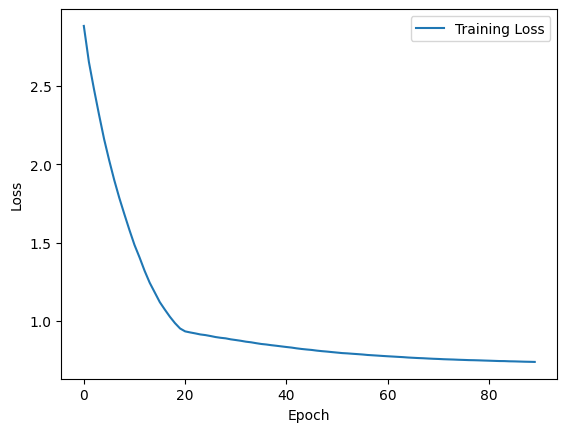

In [21]:
adata = scv.datasets.bonemarrow()
data_loader, adata, spliced_counts, unspliced_counts = preprocess_and_create_dataloader(adata, batch_size=128)
trained_vae = train_vae(adata,data_loader, num_epochs=90)

<Figure size 1200x500 with 0 Axes>

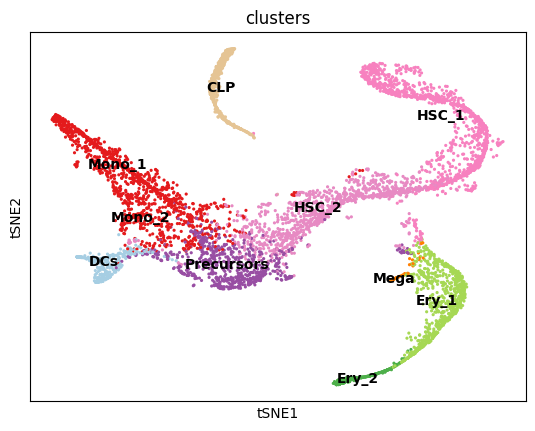

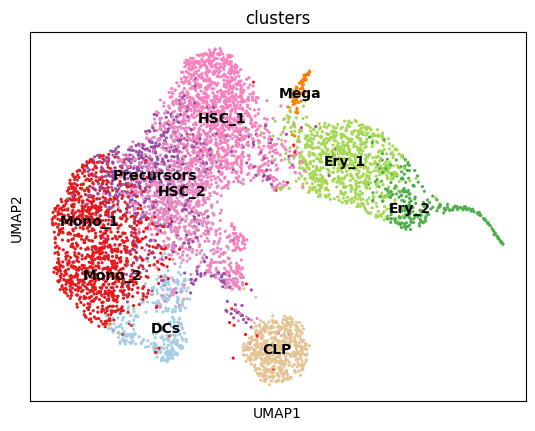

In [24]:
plot_tsne_side_by_side(adata,spliced_counts, unspliced_counts, trained_vae,'clusters')